# Bayesian Statistics Seminar

Copyright 2017 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import thinkbayes2
import thinkplot

## Survival analysis

Suppose that you are an auto insurance company interested in the time between collisions for a particular driver.  If the probability of a collision is roughly constant over time, the time between collisions will follow an exponential distribution.

Here's an example with parameter $\lambda = 0.5$.

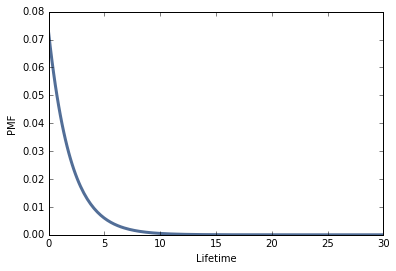

In [2]:
from thinkbayes2 import MakeExponentialPmf

pmf = MakeExponentialPmf(lam=0.5, high=30)
thinkplot.Pdf(pmf)
thinkplot.Config(xlabel='Lifetime', ylabel='PMF')

For the exponential distribution, the mean and standard deviation are $1/\lambda$.

In this case they are only approximate because we truncated the distribution.

In [3]:
pmf.Mean(), pmf.Std()

(1.9255614181751446, 1.9994621154028254)

From the PMF, we can compute the CDF.

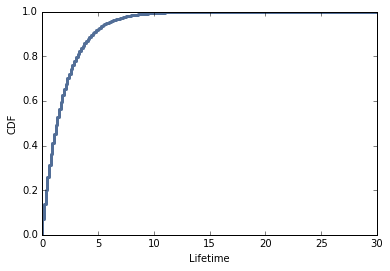

In [4]:
cdf = pmf.MakeCdf()
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Lifetime', ylabel='CDF')

And from the CDF, we can compute the survival function, which is the complement of the CDF.

$SF(x) = Prob\{X > x\} = 1 - Prob\{X \le x\} = 1 - CDF(x)$

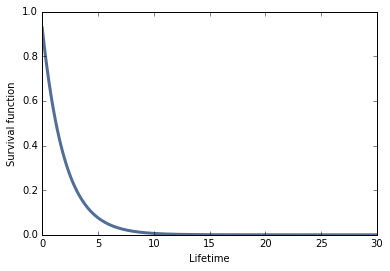

In [5]:
from survival import MakeSurvivalFromCdf

sf = MakeSurvivalFromCdf(cdf)
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Lifetime', ylabel='Survival function')

From the survival function we can get the hazard function, which is the probability of a collision at $x$, given no collision prior to $x$.

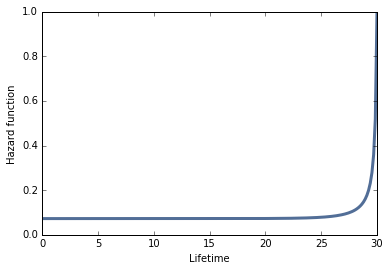

In [6]:
hf = sf.MakeHazardFunction()
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Lifetime', ylabel='Hazard function')

If the distribution is truly exponential, the hazard function is constant for all $x$.

In this case it goes to 1 at the end, again because we truncated the distribution.

**Exercise:** Go back and increase the value of `high`, and confirm that the hazard function is a constant until we approach the point where we cut off the distribution.

Given the survival function, we can compute the distribution of remaining lifetime, conditioned on current age.  The following function computes the mean remaining lifetime for a range of ages.

In [7]:
def RemainingLifetime(sf):
    """Computes remaining lifetime as a function of age.
    
    sf: survival function
    returns: Series that maps from age to remaining lifetime
    """
    pmf = sf.MakePmf()
    d = {}
    for t in sorted(pmf.Values()):
        pmf[t] = 0
        if pmf.Total():
            pmf.Normalize()
            d[t] = pmf.Mean() - t

    return pd.Series(d)

And here's what it looks like for the exponential survival function.

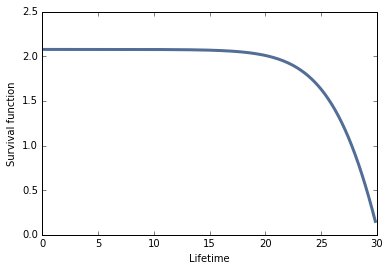

In [8]:
mean_rem_life = RemainingLifetime(sf)
thinkplot.Plot(mean_rem_life)
thinkplot.Config(xlabel='Lifetime', ylabel='Survival function')

The mean time until a collision is pretty much constant, until we approach the point where we truncate the distribution.

## The Weibull distribution

The Weibull distribution is a generalization of the exponential distribution that takes an additional "shape" parameter, `k`.

When `k=1`, the Weibull is an exponential distribution.  Other values of `k` yield survival curves with different shapes, and hazard functions that increase, decrease, or both.  So the Weibull family can capture a wide range of survival patterns.

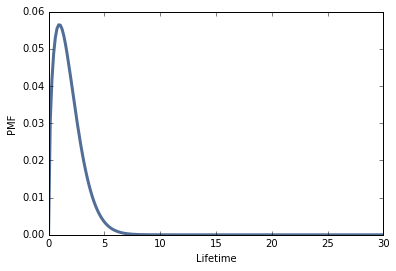

In [9]:
from thinkbayes2 import MakeWeibullPmf

pmf = MakeWeibullPmf(lam=2.0, k=1.5, high=30)
thinkplot.Pdf(pmf)
thinkplot.Config(xlabel='Lifetime', ylabel='PMF')

**Exercise**: In the previous section, replace the exponential distribution with a Weibull distribituion and run the analysis again.  What can you infer about the values of the parameters and the behavior of the hazard function and remaining lifetime?

## Bayesian survival analysis

Suppose you are the manager of a large building with many light fixtures.  To figure out how often you will need to replace lightbulbs, you install 10 bulbs and measure the time until they fail.

To generate some fake data, I'll choose a Weibull distribution and generate a random sample (let's suppose it's in years):

In [10]:
def SampleWeibull(lam, k, n=1):
    return np.random.weibull(k, size=n) * lam

data = SampleWeibull(lam=2, k=1.5, n=10)
data

array([ 3.93306269,  0.72048   ,  0.78116042,  1.22621775,  1.45191502,
        1.78698079,  3.18159171,  0.97084327,  3.00128723,  1.48932615])

**Exercise:** Write a class called `LightBulb` that inherits from `Suite` and provides a `Likelihood` function that takes an observed lifespan as data and a tuple, `(lam, k)`, as a hypothesis.  It should return a likelihood proportional to the probability of the observed lifespan in a Weibull distribution with the given parameters.

Test your method by creating a `LightBulb` object with an appropriate prior and update it with the data above.

Plot the posterior distributions of `lam` and `k`.  As the sample size increases, does the posterior distribution converge on the values of `lam` and `k` used to generate the sample?

In [11]:
# Hint

from thinkbayes2 import Suite, Joint, EvalWeibullPdf

class LightBulb(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        lam, k = hypo
        x = data
        like = 1
        return like

In [12]:
# Solution goes here

In [13]:
# Solution goes here

In [14]:
# Solution goes here

In [15]:
# Solution goes here

In [16]:
# Solution goes here

In [17]:
# Solution goes here

**Exercise:**  Go back and run this analysis again with `n=20` and see if the posterior distributions seem to be converging on the actual parameters. 

## Censored data

**Exercise:** Now suppose that instead of observing a complete lifespan, you observe a lightbulb that has operated for 1 year and is still working.  Write another version of `LightBulb` that takes data in this form and performs an update. 

In [18]:
# Hint

from thinkbayes2 import EvalWeibullCdf

class LightBulb2(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        lam, k = hypo
        x = data
        like = 1
        return like

In [19]:
# Solution goes here

In [20]:
# Solution goes here

In [21]:
# Solution goes here

In [22]:
# Solution goes here

In [23]:
# Solution goes here

In [24]:
# Solution goes here

Note: based on this data alone, we can rule out some small values of `lam` and `k`, but we can't rule out large values.  Without more data or a more informative prior, the results are not useful.

To see why, try increasing the upper bounds in the prior distribition.

**Exercise:** Suppose you install a light bulb and then you don't check on it for a year, but when you come back, you find that it has burned out.  Extend `LightBulb` to handle this kind of data, too.

In [25]:
# Hint

class LightBulb3(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        lam, k = hypo
        x = data
        like = 1
        return like

In [26]:
# Solution goes here

In [27]:
# Solution goes here

In [28]:
# Solution goes here

In [29]:
# Solution goes here

In [30]:
# Solution goes here

In [31]:
# Solution goes here

This example has some of the same problems as the previous one.  Based on this data alone, we can't pin down the parameters much.

## Pulling it together

**Exercise:** Suppose you have 15 lightbulbs installed at different times over a 10 year period.  When you observe them, some have died and some are still working.  Write a version of `LightBulb` that takes data in the form of a `(flag, x)` tuple, where:

1. If `flag` is `eq`, it means that `x` is the actual lifespan of a bulb that has died.
2. If `flag` is `gt`, it means that `x` is the current age of a bulb that is still working, so it is a lower bound on the lifespan.
3. If `flag` is `lt`, it means that `x` is the elapsed time between installation and the first time the bulb is seen broken, so it is an upper bound on the lifespan.

To help you test, I will generate some fake data.

First, I'll generate a Pandas DataFrame with random start times and lifespans.  The columns are:

* `start`: time when the bulb was installed

* `lifespan`: lifespan of the bulb in years

* `end`: time when bulb died or will die

* `age_t`: age of the bulb at t=10

In [32]:
import pandas as pd

lam = 2
k = 1.5
n = 15
t_end = 10
starts = np.random.uniform(0, t_end, n)
lifespans = SampleWeibull(lam, k, n)

df = pd.DataFrame({'start': starts, 'lifespan': lifespans})
df['end'] = df.start + df.lifespan
df['age_t'] = t_end - df.start

df.head()

,lifespan,start,end,age_t
0,0.812265,1.451079,2.263344,8.548921
1,2.010584,3.822779,5.833363,6.177221
2,0.404421,1.048181,1.452601,8.951819
3,0.506743,3.503315,4.010057,6.496685
4,1.014877,4.508463,5.523340,5.491537


Now I'll process the DataFrame to generate data in the form we want for the update.

In [33]:
data = []
for i, row in df.iterrows():
    if row.end < t_end:
        data.append(('eq', row.lifespan))
    else:
        data.append(('gt', row.age_t))
        
for pair in data:
    print(pair)

('eq', 0.81226508619456328)
('eq', 2.0105842471709634)
('eq', 0.40442059107469491)
('eq', 0.50674258157079088)
('eq', 1.0148765503730666)
('eq', 2.265141425374412)
('eq', 1.3281182217357757)
('gt', 2.25256715166429)
('gt', 0.46707158609037691)
('eq', 2.7495410426490592)
('eq', 0.25270950048067764)
('eq', 2.0144323296919548)
('eq', 1.0093772276491204)
('eq', 1.5122724223847952)
('eq', 1.4181328310784498)


In [34]:
# Solution goes here

In [35]:
# Solution goes here

In [36]:
# Solution goes here

In [37]:
# Solution goes here

In [38]:
# Solution goes here

## Prediction

Suppose we know that, for a particular kind of lightbulb in a particular location, the distribution of lifespans is well modeled by a Weibull distribution with `lam=2` and `k=1.5`.  If we install `n=100` lightbulbs and come back one year later, what is the distribution of `c`, the number of lightbulbs that have burned out?

The probability that any given bulb has burned out comes from the CDF of the distribution.

In [39]:
lam = 2
k = 1.5
p = EvalWeibullCdf(1, lam, k)
p

0.29781149867344037

The number of bulbs that have burned out is distributed Binom(n, p).


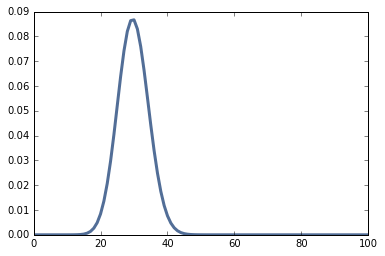

In [40]:
from thinkbayes2 import MakeBinomialPmf

n = 100
pmf_c = MakeBinomialPmf(n, p)
thinkplot.Pdf(pmf_c)

Or we can approximate the distribution with a random sample.

(29.827999999999999, 4.4346833032359818)

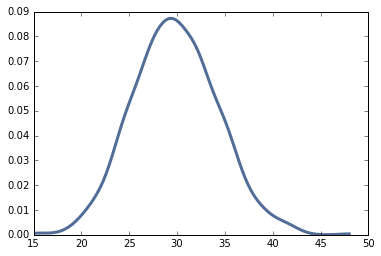

In [41]:
n = 100
sample = np.random.binomial(n, p, 1000)
pdf_c = thinkbayes2.EstimatedPdf(sample)
thinkplot.Pdf(pdf_c)
np.mean(sample), np.std(sample)

**Exercise:** Now suppose that `lam` and `k` are not known precisely, but we have a `LightBulb` object that represents the joint posterior distribution of the parameters after seeing some data.  Compute the posterior predictive distribution for `c`, the number of bulbs burned out after one year.

In [42]:
# Solution goes here

In [43]:
# Solution goes here

In [44]:
# Solution goes here

In [45]:
# Solution goes here